['/Users/yiming/Development/radossim/experiments/latModel/BlueStore/batch01', '/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python37.zip', '/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7', '/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/lib-dynload', '', '/usr/local/lib/python3.7/site-packages', '/usr/local/Cellar/protobuf/3.10.0/libexec/lib/python3.7/site-packages', '/usr/local/lib/python3.7/site-packages/IPython/extensions', '/Users/yiming/.ipython']


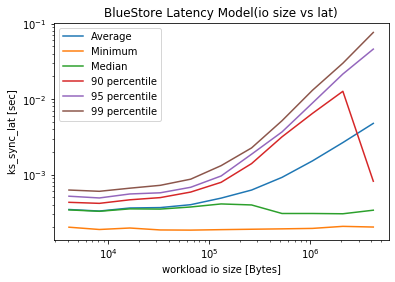

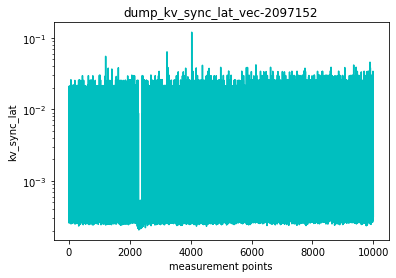

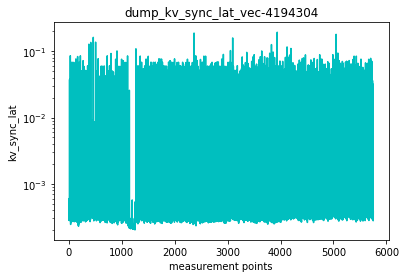

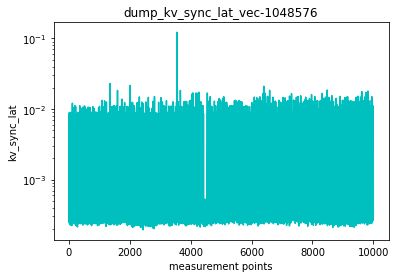

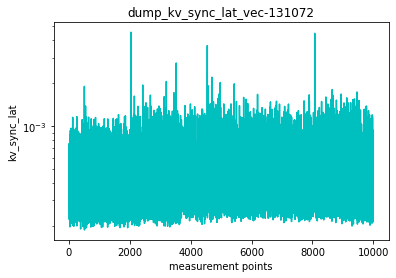

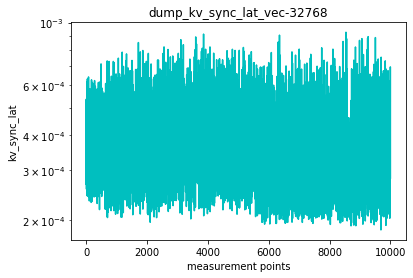

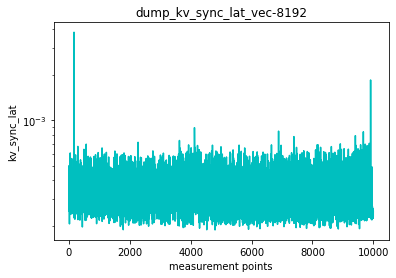

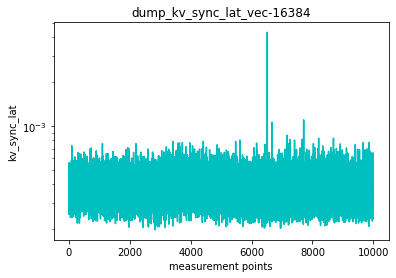

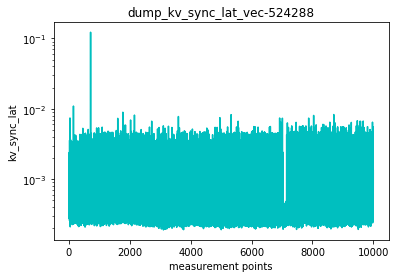

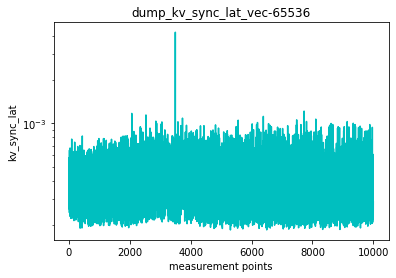

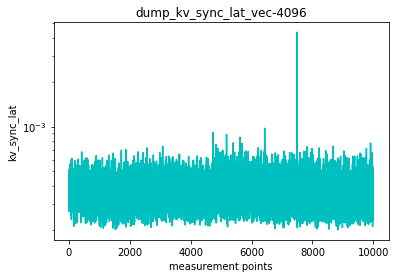

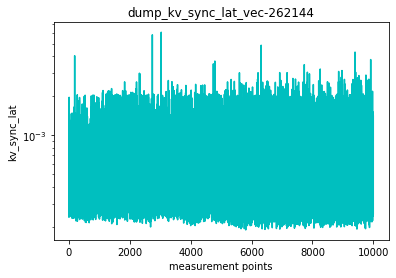

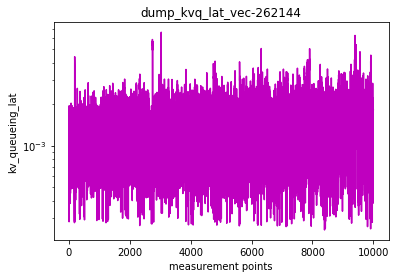

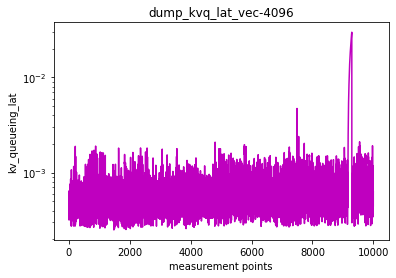

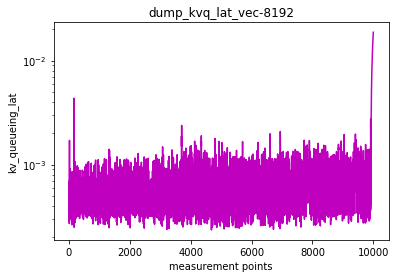

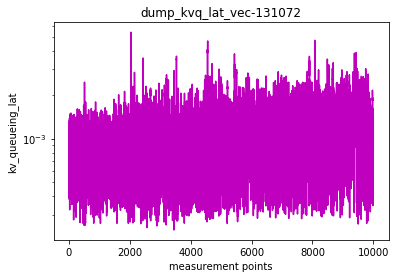

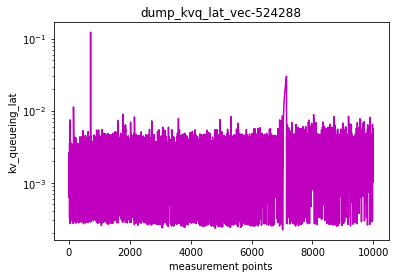

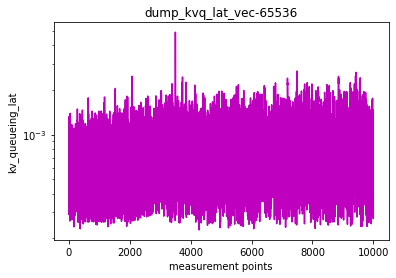

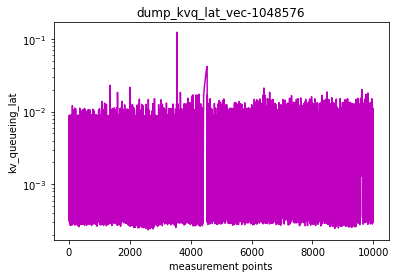

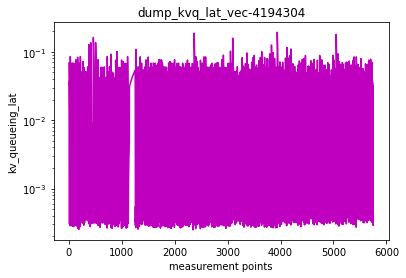

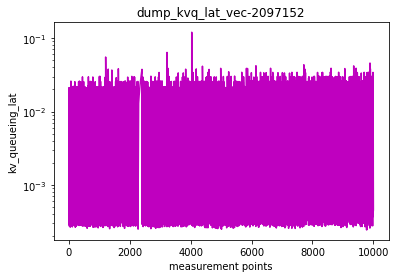

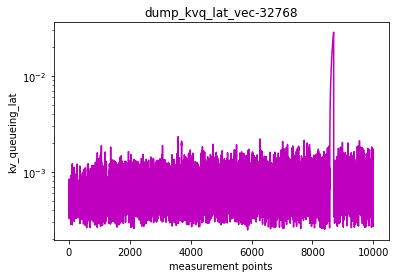

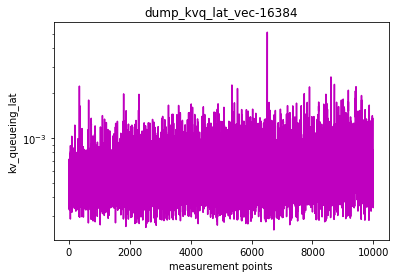

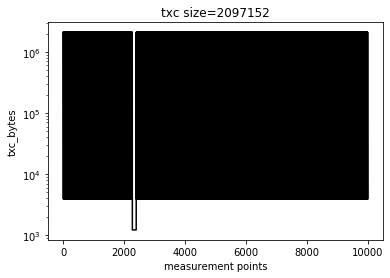

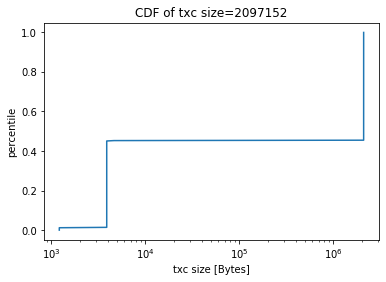

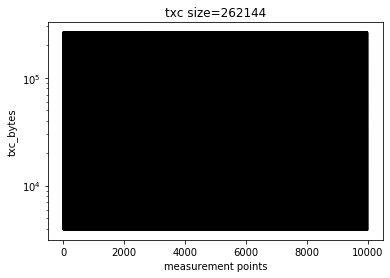

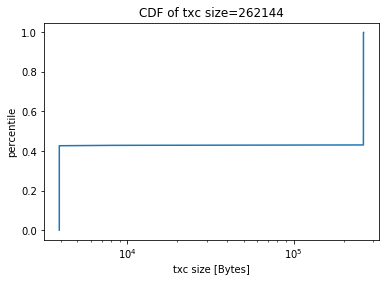

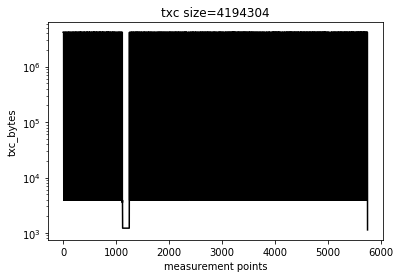

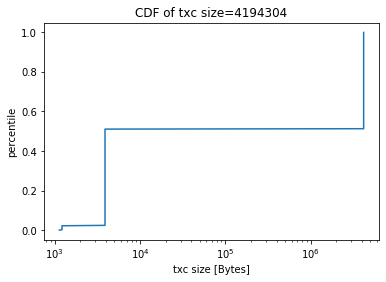

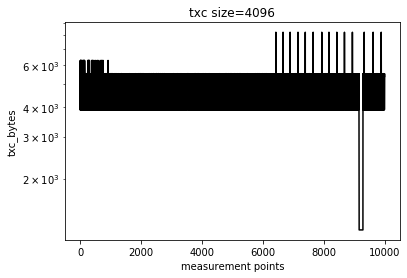

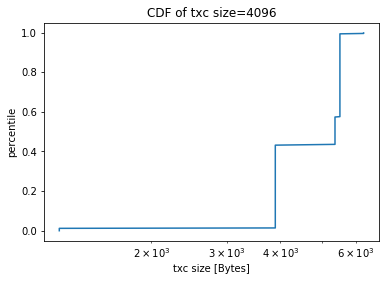

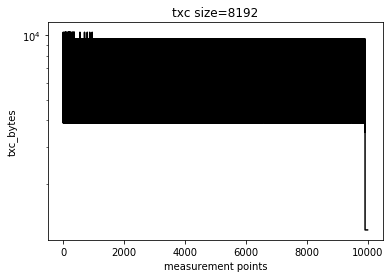

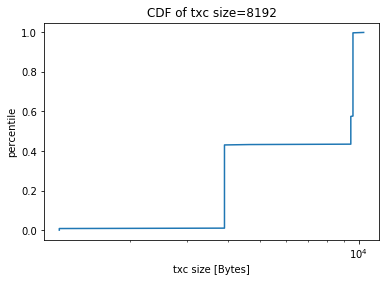

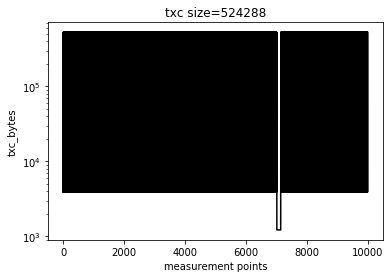

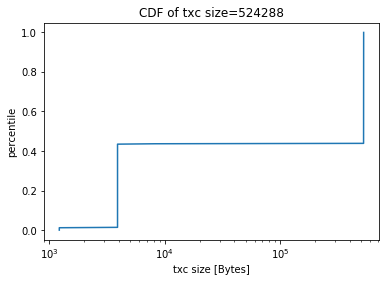

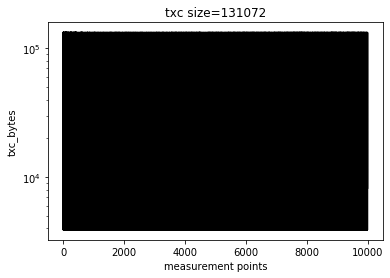

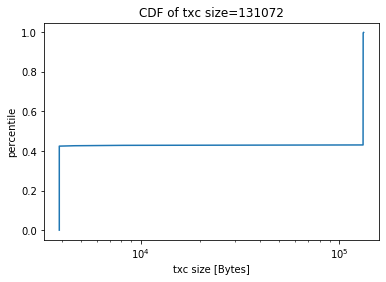

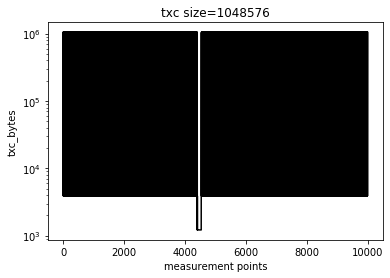

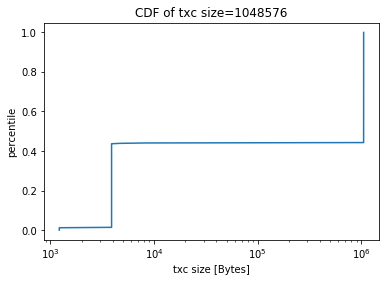

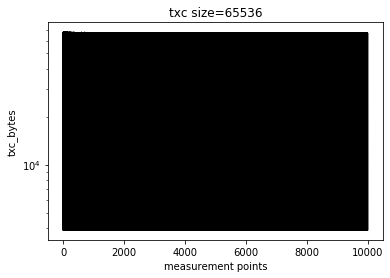

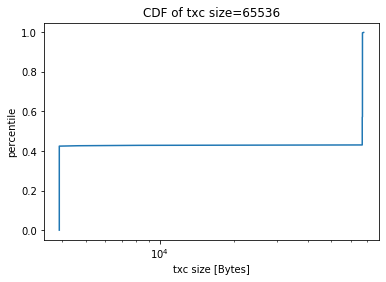

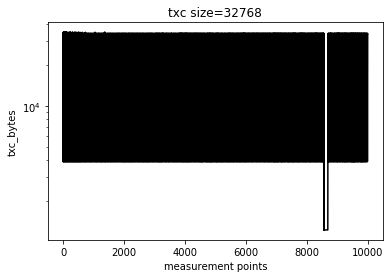

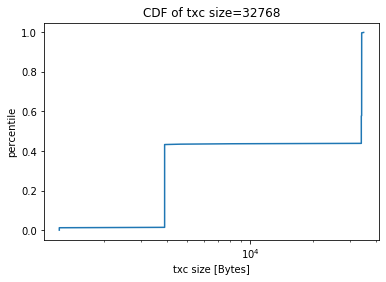

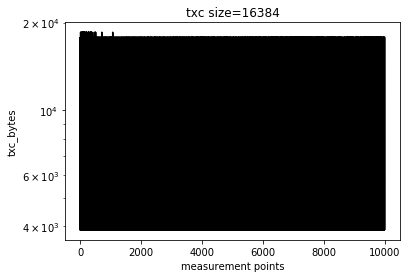

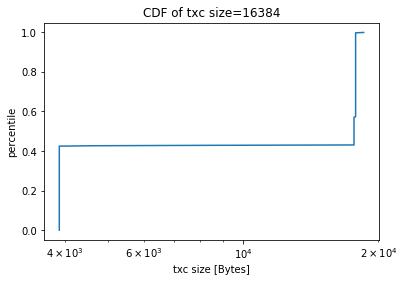

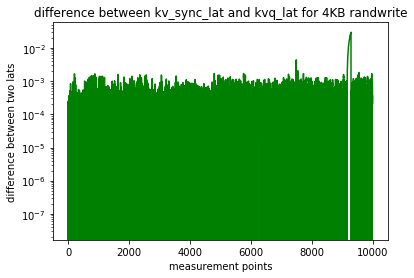

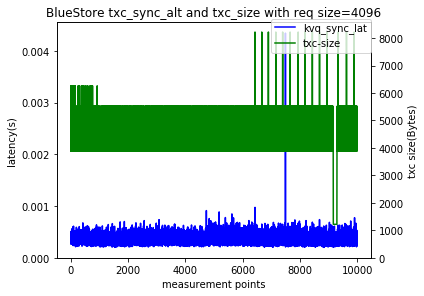

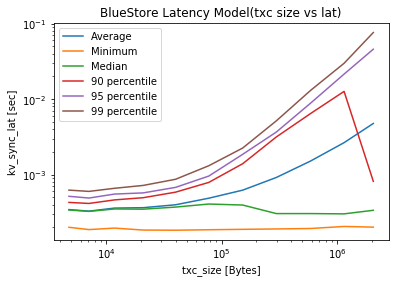

In [148]:
import sys
print(sys.path)

import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv
import pandas as pd
import glob

# process raw data (these csvs are raw data)
# use (eg: nrows=50) to control how many data points are needed

# plot the BlueStore Latency Model(workload IO size vs kv_sync_lat(flush+commit))
x = []
y_min = []
y_avg = []
y_med = []
y_p90 = []
y_p95 = []
y_p99 = []
for f in glob.glob('dump_kv_sync_lat_vec*.csv'):
    bs=f.split('-')[1].split('.')[0]
    x.append(int(bs))
x.sort()
for i in x:
    fname='dump_kv_sync_lat_vec-'+str(i)+'.csv'
    data1=read_csv(fname, header=0, skiprows=1000, nrows=10000, parse_dates=True, squeeze=True).sort_values(ignore_index=True)
    datalen=len(data1)
    avg = sum(data1) / datalen
    median = data1[int(.5 * datalen - 1)]
    pct90 = data1[int(.90 * datalen - 1)]
    pct95 = data1[int(.95 * datalen - 1)]
    pct99 = data1[int(.99 * datalen - 1)]
    y_min.append(data1[0])
    y_avg.append(avg)
    y_med.append(median)
    y_p90.append(pct90)
    y_p95.append(pct95)
    y_p99.append(pct99)
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(x, y_avg, label='Average')
ax.plot(x, y_min, label='Minimum')
ax.plot(x, y_med, label='Median')
ax.plot(x, y_p90, label='90 percentile')
ax.plot(x, y_p95, label='95 percentile')
ax.plot(x, y_p99, label='99 percentile')
ax.set(xlabel='workload io size [Bytes]', ylabel='ks_sync_lat [sec]', title='BlueStore Latency Model(io size vs lat)')
plt.legend()
plt.show()
plt.close()

# plot kv_sync_lat in BlueStore(including flushing and committing latencies)
for f in glob.glob('dump_kv_sync_lat_vec*.csv'):
    data1 = read_csv(f, header=0, skiprows=1000, nrows=10000, parse_dates=True, squeeze=True)
    fig1 = plt.figure(1)
    ax1 = fig1.add_subplot(111)
    line1 = data1.plot(style='c-', label='kv_sync_lat')
    ax1.set_xlabel('measurement points')
    ax1.set_ylabel('kv_sync_lat')
    plt.yscale('log')
    ax1.set_title(f.split(".")[0])
    plt.show()
    figname=f.split(".")[0] + ".png"
    #plt.savefig(figname, bbox_inches='tight')
    plt.close()

# plot kvq_lat in BlueStore(including kv_queue queueing latency and kv_sync_lat)    
for f in glob.glob('dump_kvq_lat_vec*.csv'):
    data1 = read_csv(f, header=0, skiprows=1000, nrows=10000, parse_dates=True, squeeze=True)
    fig1 = plt.figure(1)
    ax1 = fig1.add_subplot(111)
    line1 = data1.plot(style='m-', label='kv_queueing_lat')
    ax1.set_xlabel('measurement points')
    ax1.set_ylabel('kv_queueing_lat')
    plt.yscale('log')
    ax1.set_title(f.split(".")[0])
    plt.show()
    figname=f.split(".")[0] + ".png"
    #plt.savefig(figname, bbox_inches='tight')
    plt.close()

# plot txc size over time in BlueStore
for f in glob.glob('dump_txc_bytes_vec*.csv'):
    data1 = read_csv(f, header=0, skiprows=1000, nrows=10000, parse_dates=True, squeeze=True)
    datalen=len(data1)
    avg = sum(data1) / datalen
    bs=(f.split('.')[0]).split('-')[1]
    #fig, axes = plt.subplots(nrows=1, ncols=2)
    fig, ax = plt.subplots()
    data1.plot(ax=ax, style='k-', label='txc_bytes')
    ax.set_xlabel('measurement points')
    ax.set_ylabel('txc_bytes')
    ax.set_title("txc size="+str(bs))
    ax.set_yscale('log')
    
    data2=data1.sort_values(ignore_index=True)
    x1 = []
    y1 = []
    for i in range(0, 1000, 2):
        #print(data2[int(i/datalen * datalen)])
        x1.append(data2[int(i/1000. * datalen)])
        y1.append(i/1000.)
    #x1.append(data2[datalen-1])
    #y1.append(1.0)
    fig, ax = plt.subplots()
    ax.plot(x1, y1, label='CDF')
    ax.set_xscale('log')
    ax.set(xlabel='txc size [Bytes]', ylabel='percentile', title='CDF of txc size='+str(bs))
    plt.show()
    plt.close()

# verify the latency in BlueStore for 4KB
data1 = read_csv('dump_kvq_lat_vec-4096.csv', header=0, skiprows=1000, nrows=10000, parse_dates=True, squeeze=True)
data2 = read_csv('dump_kv_sync_lat_vec-4096.csv', header=0, skiprows=1001, nrows=10000, parse_dates=True, squeeze=True)
temp = data1 - data2
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)
line1 = temp.plot(style='g-', label='difference between two lats')
ax1.set_xlabel('measurement points')
ax1.set_ylabel('difference between two lats')
ax1.set_title('difference between kv_sync_lat and kvq_lat for 4KB randwrite')
plt.yscale('log')
plt.show()
plt.savefig('difference-between-kv_sync_lat-and-kvq_lat.png', bbox_inches='tight')
plt.close()

for i in range(1):
    s = (2**i) * 4096
    f1 = 'dump_kv_sync_lat_vec-'+str(s)+'.csv'
    f2 = 'dump_txc_bytes_vec-'+str(s)+'.csv'
    series1 = read_csv(f1, header=0, skiprows=1000, nrows=10000, parse_dates=True, squeeze=True)
    series2 = read_csv(f2, header=0, skiprows=1000, nrows=10000, parse_dates=True, squeeze=True)
    # fig1 is to show the correlation between txc size and kv_sync_lat 
    fig1 = plt.figure(1)
    ax1 = fig1.add_subplot(111)
    series1.plot(style='b-', label='kvq_sync_lat')
    ax1.set_xlabel('measurement points')
    ax1.set_ylabel('latency(s)')
    ax1.set_ylim(0)
    ax2 = ax1.twinx()
    series2.plot(style='g-', label='txc-size')
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel('txc size(Bytes)')
    ax2.set_ylim(0)
    fig1.tight_layout()
    fig1.legend(loc='upper right', bbox_to_anchor=(0.87, 0.98))
    plt.title("BlueStore txc_sync_alt and txc_size with req size="+str(s), y=1.02)
    plt.show()
    plt.close()

# plot the BlueStore Latency Model(txc size vs kv_sync_lat(flush+commit))
x_txc = []
for i in range(11):
    s = (2**i) * 4096
    f1 = 'dump_txc_bytes_vec-'+str(s)+'.csv'
    txc_size_df = read_csv(f1, header=0, skiprows=1000, nrows=10000, parse_dates=True, squeeze=True)
    txc_size_list = txc_size_df.to_numpy()
    x_txc.append(np.average(txc_size_list))    
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(x_txc, y_avg, label='Average')
ax.plot(x_txc, y_min, label='Minimum')
ax.plot(x_txc, y_med, label='Median')
ax.plot(x_txc, y_p90, label='90 percentile')
ax.plot(x_txc, y_p95, label='95 percentile')
ax.plot(x_txc, y_p99, label='99 percentile')
ax.set(xlabel='txc_size [Bytes]', ylabel='kv_sync_lat [sec]', title='BlueStore Latency Model(txc size vs lat)')
plt.legend()
plt.show()
plt.close()

[4759.4449, 7096.2188, 11825.3156, 20925.3247, 39894.5123, 77334.6074, 152098.2964, 297469.2348, 588824.2227, 1147541.1363] 10
10


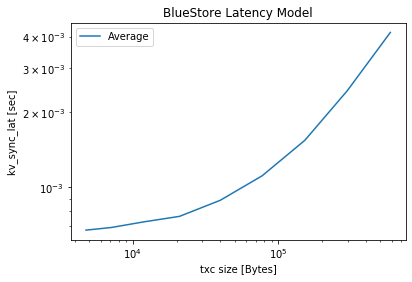

In [63]:
# plot the BlueStore Latency Model(txc size vs kv_sync_lat(flush+commit))
'''x_txc = []
for i in range(11):
    s = (2**i) * 4096
    f1 = 'dump_txc_bytes_vec-'+str(s)+'.csv'
    txc_size_df = read_csv(f1, header=0, skiprows=1000, nrows=10000, parse_dates=True, squeeze=True).sort_values(ignore_index=True)
    txc_size_list = txc_size_df.to_numpy()
    x_txc.append(np.average(txc_size_list))    
#print(x_txc)
bins = x_txc
#bins=np.logspace(np.log10(x_txc[0]),np.log10(x[10]), 10)
#pl.hist(data, bins=np.logspace(np.log10(0.1),np.log10(1.0), 50))
#print(bins)'''
'''fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(x_txc, y_avg, label='Average')
ax.plot(x_txc, y_min, label='Minimum')
ax.plot(x_txc, y_med, label='Median')
ax.plot(x_txc, y_p90, label='90 percentile')
ax.plot(x_txc, y_p95, label='95 percentile')
ax.plot(x_txc, y_p99, label='99 percentile')
ax.set(xlabel='txc_size [Bytes]', ylabel='kv_sync_lat [sec]', title='BlueStore Latency Model(txc size vs lat)')
plt.legend()
plt.show()
plt.close()'''

'''n, bins, patches = ax.hist(data2, n_bins, density=True, histtype='step',cumulative=True, label='CDF')
    ax.set_xlabel('txc size')
    ax.set_ylabel('liklyhood of occurrence')
    ax.set_title("txc size CDF")
    fig.suptitle(f.split(".")[0])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    figname=f.split(".")[0] + ".png"
    plt.savefig(figname, bbox_inches='tight')
    plt.close()'''
from scipy.optimize import curve_fit

# create bins for txc size
x_txc = []
for i in range(10):
    s = (2**i) * 4096
    f1 = 'dump_txc_bytes_vec-'+str(s)+'.csv'
    txc_size_df = read_csv(f1, header=0, skiprows=1000, nrows=10000, parse_dates=True, squeeze=True).sort_values(ignore_index=True)
    txc_size_list = txc_size_df.to_numpy()
    x_txc.append(np.average(txc_size_list))    
bins = x_txc
print(bins,len(bins))
#np.histogram()
# collect latencies for different txc size bins
y_min = []
y_avg = []
y_med = []
y_p90 = []
y_p95 = []
y_p99 = []
binSize = len(bins)
print(binSize)
for i in range(binSize):
    s1 = (2**i) * 4096
    s2 = (2**(i+1)) * 4096
    f1='dump_kv_sync_lat_vec-'+str(s1)+'.csv'
    f2='dump_kv_sync_lat_vec-'+str(s2)+'.csv'
    data1=read_csv(f1, header=0, skiprows=1000, nrows=10000, parse_dates=True, squeeze=True).sort_values(ignore_index=True)
    data2=read_csv(f2, header=0, skiprows=1000, nrows=10000, parse_dates=True, squeeze=True).sort_values(ignore_index=True)
    data = (data1 + data2).sort_values(ignore_index=True)
    datalen=len(data)
    avg = sum(data) / datalen
    median = data[int(.5 * datalen - 1)]
    pct90 = data[int(.90 * datalen - 1)]
    pct95 = data[int(.95 * datalen - 1)]
    pct99 = data[int(.99 * datalen - 1)]
    y_min.append(data[0])
    y_avg.append(avg)
    y_med.append(median)
    y_p90.append(pct90)
    y_p95.append(pct95)
    y_p99.append(pct99)


fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(x_txc, y_avg, label='Average')
'''ax.plot(x, y_min, label='Minimum')
ax.plot(x, y_med, label='Median')
ax.plot(x, y_p90, label='90 percentile')
ax.plot(x, y_p95, label='95 percentile')
ax.plot(x, y_p99, label='99 percentile')'''
ax.set(xlabel='txc size [Bytes]', ylabel='kv_sync_lat [sec]', title='BlueStore Latency Model')
plt.legend()
plt.show()
plt.close()

# fit for the parameters
popt, pcov = curve_fit(func, xdata, ydata)

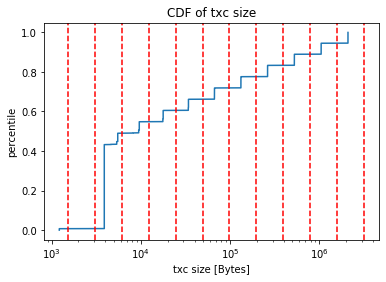

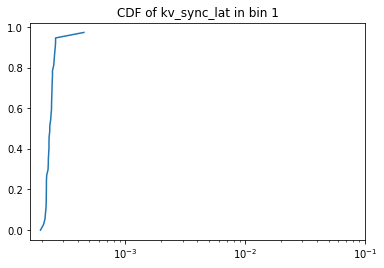

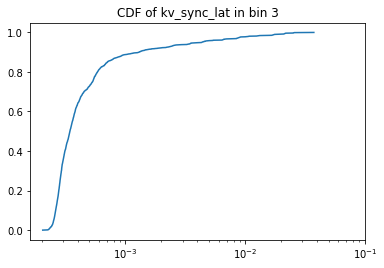

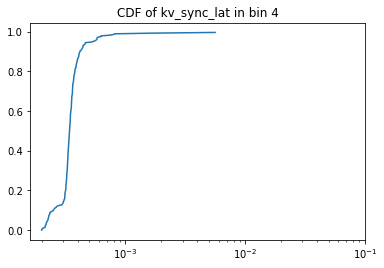

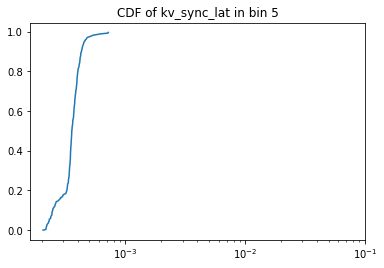

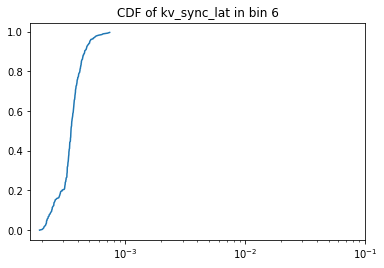

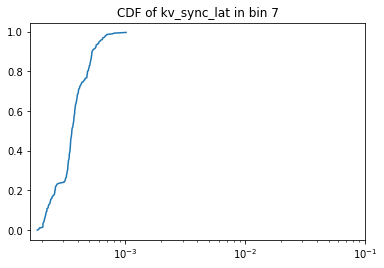

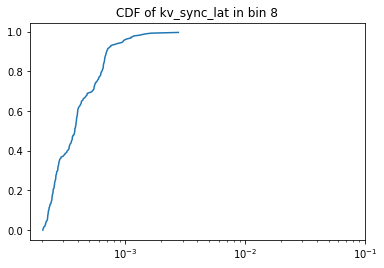

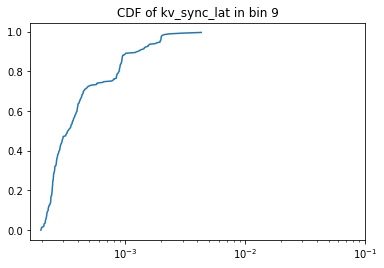

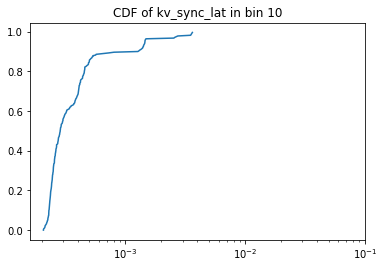

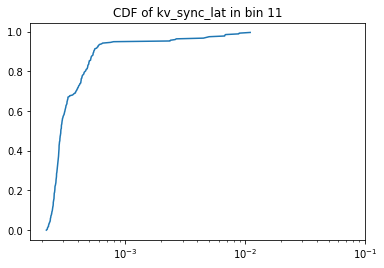

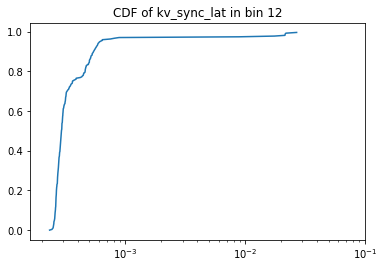

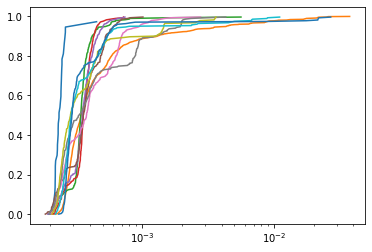

In [266]:
df = pd.DataFrame() # concated dataframe with txc_size and kv_sync_lat
for i in range(10):
    s1 = (2**i) * 4096
    f1='dump_txc_bytes_vec-'+str(s1)+'.csv'
    f2='dump_kv_sync_lat_vec-'+str(s1)+'.csv'
    data1 = read_csv(f1, header=0, skiprows=1000, nrows=10000, parse_dates=True, squeeze=True)
    data2 = read_csv(f2, header=0, skiprows=1000, nrows=10000, parse_dates=True, squeeze=True)
    temp = pd.concat([data1, data2], axis=1, ignore_index=True)
    df = pd.concat([df,temp]) 
df = df.sort_values(by=[0],ignore_index=True) # sort by column 0, which is txc_size
dfLen = len(df)
x_df = [] # store txc_size
x_df_lat = [] # store corresponding kv_sync_lat
y_df = [] # store percentile
# generate CDF dataset(x: txc_size; y: percentile)
for i in range(0, 10000, 2):
    x_df.append(df[0][int(i/10000. * dfLen)])
    x_df_lat.append(df[1][int(i/10000. * dfLen)])
    y_df.append(i/10000.)
    
fig, ax = plt.subplots()
ax.plot(x_df, y_df, label='CDF')
ax.set_xscale('log')
ax.set(xlabel='txc size [Bytes]', ylabel='percentile', title='CDF of txc size')
bin_x = [0.0, 1536.0]
plt.axvline(x=1536 , color='r', ls='--')
for i in range(0,11):
    plt.axvline(x=(2**i - (2**(i+1) - 2**i)/4)*4096, color='r', ls='--')
    bin_x.append((2**i - (2**(i+1) - 2**i)/4)*4096)
#print(bin_x)
plt.show()
plt.close()

#binnedData = pd.cut(x_df,bin_x)

binnedDataIndex = [] # store the binned data indices grouped by bin number
bin_indices = np.digitize(x_df, bin_x)
unq_bin_indices = np.unique(bin_indices)
for i in unq_bin_indices:
    temp_bin = []
    for idx, val in enumerate(bin_indices):
        if i == val:
            temp_bin.append(idx)
    binnedDataIndex.append(temp_bin)
#print(bin_indices)
#print(binnedDataIndex)
#print(len(binnedDataIndex)) 
binned_lat = [] # stores the sorted, binned, kv_sync_lat

bin_count = 0
for i in binnedDataIndex:
    bin_idx = unq_bin_indices[bin_count]
    bin_count += 1 
    temp_bin = []
    for j in i:
        temp_bin.append(x_df_lat[j])
    temp_bin.sort()
    binned_lat.append(temp_bin)
    temp_bin_size = len(temp_bin) 
    x_binned_lat = []
    y_binned_pc = []
    for k in range(0, temp_bin_size, 1):
        x_binned_lat.append(temp_bin[int(k/temp_bin_size * temp_bin_size)])
        y_binned_pc.append(k/temp_bin_size) 
    plt.figure()
    plt.plot(x_binned_lat, y_binned_pc, label='CDF')
    plt.xscale('log')
    plt.xlim(1.6*10e-5,0.1*10e-1)
    plt.title("CDF of kv_sync_lat in bin "+str(bin_idx))
    plt.show()
    plt.close()

# plot all binned latencies in one graph
fig, ax = plt.subplots()
for i in binned_lat:
    x_binned_lat = []
    y_binned_pc = []
    for k in range(0, len(i), 1):
        x_binned_lat.append(i[int(k/len(i) * len(i))])
        y_binned_pc.append(k/len(i))
    ax.plot(x_binned_lat, y_binned_pc, label='CDF') # TODO: need to be normalized
ax.set_xscale('log')
plt.show()


# create CDF on size(may have steps; flat: low dencity; up: high dencity; capture steep section in one bucket)
# bucketize